# Analyzing borrowers’ risk of defaulting

This project is an assignment of the Data Scientist training program provided by Practicum - Yandex. This project prepares a report for a bank’s loan division to find out if a customer’s number of children, marital status, income level and purpose of loan have an impact on whether they will default on a loan. This report is the foundation to develop credit scoring later. Credit scoring is used to evaluate the ability of a potential borrower to repay their loan.

## Step 1. Open the data file and have a look at the general information. 

In [1]:
#Import pandas, read data and examine the general info
import pandas as pd
data = pd.read_csv('https://code.s3.yandex.net/datasets/credit_scoring_eng.csv')
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding
5,0,-926.185831,27,bachelor's degree,0,civil partnership,1,M,business,0,40922.170,purchase of the house
6,0,-2879.202052,43,bachelor's degree,0,married,0,F,business,0,38484.156,housing transactions
7,0,-152.779569,50,SECONDARY EDUCATION,1,married,0,M,employee,0,21731.829,education
8,2,-6929.865299,35,BACHELOR'S DEGREE,0,civil partnership,1,F,employee,0,15337.093,having a wedding
9,0,-2188.756445,41,secondary education,1,married,0,M,employee,0,23108.150,purchase of the house for my family


### Conclusion

There are 21,525 observations (rows) and 12 variables (columns) in this dataset. Data types include integer, float number and string. One row in the table represents a potential customer of the bank, there is no customer_id column. 'days_employed' column contains negative values and too big number of days (e.g.340266 days ~ 932 years), which might have been incorrectly inputted. 

## Step 2. Data preprocessing

### Processing missing values

In [2]:
#check missing values
data[data['days_employed'].isnull()].count()

children            2174
days_employed          0
dob_years           2174
education           2174
education_id        2174
family_status       2174
family_status_id    2174
gender              2174
income_type         2174
debt                2174
total_income           0
purpose             2174
dtype: int64

In [3]:
data[data['total_income'].isnull()].count()

children            2174
days_employed          0
dob_years           2174
education           2174
education_id        2174
family_status       2174
family_status_id    2174
gender              2174
income_type         2174
debt                2174
total_income           0
purpose             2174
dtype: int64

####Sub-conclusion: Missingness occurs in the following columns (by looking at "non null object" in the info section and confirm via 'isnull()' command): 'days_employed' , 'total_income' - 2174 rows without info about days employed and total income.

In [4]:
#Find out how to replace missing values in the "days_employed" column
#change values in the days_employed column to positive value by taking the absolute value
data['days_employed'] = data['days_employed'].abs()
data['days_employed'].min()
data['days_employed'].max() #401755.40047533
#works ok with negative values, but there are outliers 
# --> it's better to use median to impute for missing value, but need to compare between mean and median

401755.40047533

In [5]:
days_employed_median = data['days_employed'].median()
days_employed_median #2194.220566878695
days_employed_mean = data['days_employed'].mean()
days_employed_mean #66914.72890682236
#The gap beteeen mean and median is very large, highly suspected for outliers
#safer to use median because we do not know the range for a number to be an outlier 
#(except if we can detect outliers by the IQR*1.5 rule: values might be outliers: < or > Q1- or Q3+ IQR*1.5)

66914.72890682236

In [6]:
#Replace missing values in the days_employed column by the median value
data['days_employed'] = data['days_employed'].fillna(value = days_employed_median)
#Check it the replacement works
data[data['days_employed'].isnull()].count() #worked

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

In [7]:
#Find out how to replace missing values in the "total_income" column
#Investigate the value range
data['total_income'].min() #3306.762
data['total_income'].max() #362496.645
data['total_income'].mean() #26787.56835465867
data['total_income'].median() #23202.87
#The gap between mean and median is not large
#Might use mean, but use with category-wise, i.e. people from the same group (education) have the same mean
#Picking "education" because education is proven to associate with income in previous literature

23202.87

In [8]:
#Investigate the education and education_id columns
data['education'].unique()
data['education_id'].unique() #0, 1, 2, 3, 4
data.loc[data['education_id'] == 0] #bachelor's degree
data.loc[data['education_id'] == 1] #secondary education
data.loc[data['education_id'] == 2] #some college
data.loc[data['education_id'] == 3] #primary education
data.loc[data['education_id'] == 4] #graduate degree
#a bit weird, not in any proper order. Should have been either ascending or descending order
#0: primary education, 1: secondary education, 2: some college, 3: bachelor's degree, 4: graduate degree
#but not important here, so ignore

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2963,0,337584.815560,69,Graduate Degree,4,married,0,M,retiree,0,15800.399,buy residential real estate
4170,0,409.200149,45,GRADUATE DEGREE,4,unmarried,4,M,employee,0,31771.321,transactions with commercial real estate
6551,0,5352.038180,58,graduate degree,4,married,0,M,employee,0,42945.794,going to university
12021,3,5968.075884,36,graduate degree,4,married,0,F,civil servant,0,17822.757,purchase of the house
12786,0,376276.219531,62,graduate degree,4,married,0,F,retiree,0,40868.031,buy residential real estate
21519,1,2351.431934,37,graduate degree,4,divorced,3,M,employee,0,18551.846,buy commercial real estate


Sub-conclusion: There are 5 unique values in the "education" column, primary education, secondary education, some college, bachelor's degree, graduate degree. But they have been mixed up by incoherent capital/small letters. Need to change all to lowercase.

In [9]:
#change to lowercase
data['education'] = data['education'].str.lower()
data['education'].unique()

array(["bachelor's degree", 'secondary education', 'some college',
       'primary education', 'graduate degree'], dtype=object)

In [10]:
#replace missing value in the total_income column based on education groups ('education_id')
data['total_income'] = data['total_income'].fillna(data.groupby('education_id')['total_income'].transform('mean'))

#Check if the replacement works
data[data['total_income'].isnull()].count() #worked
data.isnull().sum() #finished processing missing values

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Conclusion

. Missingness occured in the "days_employed" and "total_income" columns. These are quantitative data
. Possible reasons for missing values: human error, people don't want to reveal their income.
. How the missing values were filled: processed by 2 methods:
  . Apply general mean value for 'days_employed' for all missing values 
  . Apply mean value for 'total_income' based on another variable ('education_id')

### Data type replacement

In [11]:
#Already change type of "days_employed" above
#Other variables are in their correct form, except for "children"
data['children'].value_counts() #weird value: -1 and 20
data['children'] = data['children'].abs() #take absolute value
data['children'].value_counts() #checked, ok!
data['education_id'].value_counts()
data['family_status_id'].value_counts()
data['family_status'].value_counts()
data['gender'].value_counts()
data['income_type'].value_counts()
data['debt'].value_counts()

0    19784
1     1741
Name: debt, dtype: int64

### Conclusion

Only need to change data type of "days_employed"

### Processing duplicates

In [12]:
#Check suspected duplicates because of capital/lower case, or word usage
data['family_status'].unique()
#No suspected duplicates in the categories

array(['married', 'civil partnership', 'widow / widower', 'divorced',
       'unmarried'], dtype=object)

In [13]:
data['gender'].unique()
#No suspected duplicates in the categories

array(['F', 'M', 'XNA'], dtype=object)

In [14]:
data['income_type'].unique()
#No suspected duplicates in the categories

array(['employee', 'retiree', 'business', 'civil servant', 'unemployed',
       'entrepreneur', 'student', 'paternity / maternity leave'],
      dtype=object)

In [15]:
#Identify duplicates based on all columns

duplicateRowsDF = data[data.duplicated(keep = False)] #keep = False to check if they really have the same values across columns
duplicateRowsDF.sort_values(by = 'dob_years').head(50)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
20297,1,2194.220567,23,secondary education,1,civil partnership,1,F,employee,0,24594.503037,to have a wedding
8853,1,2194.220567,23,secondary education,1,civil partnership,1,F,employee,0,24594.503037,to have a wedding
15892,0,2194.220567,23,secondary education,1,unmarried,4,F,employee,0,24594.503037,second-hand car purchase
19321,0,2194.220567,23,secondary education,1,unmarried,4,F,employee,0,24594.503037,second-hand car purchase
3452,0,2194.220567,29,bachelor's degree,0,married,0,M,employee,0,33142.802434,buy residential real estate
18328,0,2194.220567,29,bachelor's degree,0,married,0,M,employee,0,33142.802434,buy residential real estate
4216,0,2194.220567,30,secondary education,1,married,0,M,employee,0,24594.503037,building a real estate
6312,0,2194.220567,30,secondary education,1,married,0,M,employee,0,24594.503037,building a real estate
18349,1,2194.220567,30,bachelor's degree,0,married,0,F,civil servant,0,33142.802434,purchase of the house for my family
8629,1,2194.220567,30,bachelor's degree,0,married,0,F,employee,0,33142.802434,buy commercial real estate


In [16]:
#drop duplicated rows based on all columns
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21454 entries, 0 to 21524
Data columns (total 12 columns):
children            21454 non-null int64
days_employed       21454 non-null float64
dob_years           21454 non-null int64
education           21454 non-null object
education_id        21454 non-null int64
family_status       21454 non-null object
family_status_id    21454 non-null int64
gender              21454 non-null object
income_type         21454 non-null object
debt                21454 non-null int64
total_income        21454 non-null float64
purpose             21454 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


### Conclusion

Duplicated rows are identifiedd if they have the same value in every column. Duplicatedness occurs possibly due to human error. There are 71 duplicated rows, resulting in the new dataframe with 21,454 rows after drop the duplicates.

<div class="alert alert-success" role="alert">
Great all steps seems reasonable.</div>

### Categorizing data and determine the relationships between specific variables and repaying a loan on time

#### Determine the relationship between having child and repaying a loan on time

How to determine: 
    - Calculate the risk of people who have children ('children >0) and also have debt (debt =1), then calculate the risk of people who don't have children (children =0) but have debt (debt =1)
    - Then compare these two risks (in percentage)
    - This calculation is based on the calculation of relative risk of disease in public health research: relative risk = risk among the exposed/risk among the unexposed. the exposed = having children, risk = having debt
    - Ref: https://www.statisticssolutions.com/relative-risk/

In [17]:
#Adding a column to dichotomized the "children" column into 2 values: True (children >0) and False (children =0)
#Create a new dataframe, group_by the having children status, calculate the risk of getting debt ('debt'=1) between those with children and those without children
#This risk is calculated by dividing the number of people with debt (with and without children) by their corresponding total number of people with and without children respectively
#In the 'agg', 'count' calculates the total number of people with/without children with debt ('debt'=1), 'mean' calculates the risk (proportion) because the values of 'debt' are 1 - 0
data['have_child'] = data['children'] > 0
child_debt_df = data.groupby('have_child')['debt'].agg(['count', 'mean']).reset_index()
child_debt_df.columns = ['have_child', 'total_people', 'risk']
child_debt_df
#Risk of the exposed (i.e. risk of getting debt among the people with children): 9.2
#Risk of the unexposed (i.e. risk of getting debt among the people without children): 7.5
#9.2 > 7.5 --> risk among the exposed > risk among the unexposed, relative risk = 9.2/7.5 = 1.23


,have_child,total_people,risk
0,False,14091,0.075438
1,True,7363,0.092082


<font color = 'red'> Sub-conclusion 1: For the question "Is there a relation between having kids and repaying a loan on time?": Yes, there is a relation between having kids and repaying a loan on time. The risk of getting debt (repaying a loan NOT on time) among people who have kids is higher compared (1.22 times) to those who don't have kids. </font> 

#### Determine the relationship between marital status and repaying a loan on time

How to determine: 
    - Expand the logic of the first assignment above to more than two groups, add risk ratio
    - Calculate the risk for each group and compare with a reference group (need to choose a reference group)
    - Ref: http://sphweb.bumc.bu.edu/otlt/MPH-Modules/EP/EP713_Association/EP713_Association4.html

In [18]:
#Investigate family_status and their corresponding id    
data['family_status'].value_counts()
data['family_status_id'].value_counts()

#Dictionary for family status: 0 - married, 1 - civil partnership, 2 - widow / widower, 3 - divorced, 4 - unmarried

#Re-group to lower the number of categories for family status based on the similar characteristics:
 ##Unmarried (new_id: 1): Not yet married - this category includes "unmarried" (old_id: 4)
 ##Married (2): Being in a marriage/partnership - this category includes "married" (0) and "civil partnership" (1)
 ##Dismarry (3): Free from the bond of marriage - this category includes "divorced" (3) and "widow / widower" (2)

#Renumber "family_status_id" based on the above rule
def get_id(data):
    if data['family_status_id'] == 4:
        return 1
    elif data['family_status_id'] == 0 or data['family_status_id'] == 1:
        return 2
    else:
        return 3

data['family_status_id_new'] = data.apply(get_id, axis = 1)
data.head(20)

#Group by the new family_status_id and count
married_debt = data.groupby('family_status_id_new')['debt'].agg(['count', 'mean']).reset_index()
married_debt.columns = ['family_status', 'count', 'risk']
print(married_debt)

#The unmarried group had a cumulative incidence of 0.098 or 9.8 per 100 people get debt, 
#while the married group had 8 per 100 and the dismarry group had 6.9 per 100.

RR_1_2 = married_debt.loc[0, 'risk']/married_debt.loc[1, 'risk']
RR_3_2 = married_debt.loc[2, 'risk']/married_debt.loc[1, 'risk']

print('The risk ratio for the unmarried group compared to the married group (the reference group) is {:.2f}'.format(RR_1_2))
print('The risk ratio for the dismarry group compared to the married group (the reference group) is {:.2f}'.format(RR_3_2))

   family_status  count      risk
0              1   2810  0.097509
1              2  16490  0.079988
2              3   2154  0.068709
The risk ratio for the unmarried group compared to the married group (the reference group) is 1.22
The risk ratio for the dismarry group compared to the married group (the reference group) is 0.86


<font color = 'red'> Sub-conclusion 2: For the question "Is there a relation between marital status and repaying a loan on time?": Yes, there is a relation between marital status and repaying a loan on time. Compared to people who are married, those who are not married have 1.22 times the risk of getting debt (not paying loan on time) (a 22% increase in risk), and those who are free from the bond of marriage have 0.86 times the risk (a 14% decrease in risk).</font> 

#### Determine the relationship between income level and repaying a loan on time

How to determine: 
    - Expand the logic of the first assignment above to more than two groups, use a slightly different approach called cumulative incidence - risk ratio
    - Calculate the risk for each group and compare with a reference group (need to choose a reference group)
    - Ref: http://sphweb.bumc.bu.edu/otlt/MPH-Modules/EP/EP713_Association/EP713_Association4.html


The risk ratio for the low income group compared to the middle income group (the reference group) is 0.90
The risk ratio for the high income group compared to the middle income group (the reference group) is 0.77


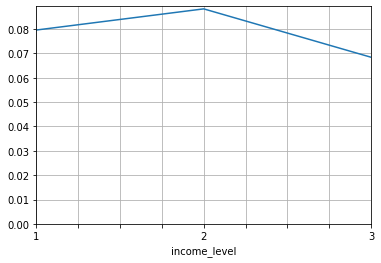

In [19]:
#Group total_income to income_level: low - medium - high based on quantile: <25%, 25% - 75% and > 75% respectively
quantile_25 = data['total_income'].quantile(.25)
quantile_75 = data['total_income'].quantile(.75)

quantile_25 #17219.81725
quantile_75 #32574.7212
#data['total_income'].min() #3306.762
#data['total_income'].max() #362496.645
#data['total_income'].mean() #26787.56835465867
#data['total_income'].median() #23202.87

#Create a function to assign income_level value based on the following rule
def get_income(data):
    if data['total_income'] < quantile_25:
        return '1' #low
    elif data['total_income'] > quantile_75:
        return '3' #high
    else:
        return '2'

data['income_level'] = data.apply(get_income, axis = 1)
data.head(20)
data['income_level'].value_counts()
data.groupby('income_level')['debt'].mean().plot(grid = True, ylim = 0)


#Group by the income_level and count
income_debt = data.groupby('income_level')['debt'].agg(['count', 'mean']).reset_index()
income_debt.columns = ['income_level', 'count', 'risk']

RR_1_2_income = income_debt.loc[0, 'risk']/income_debt.loc[1, 'risk']
RR_3_2_income = income_debt.loc[2, 'risk']/income_debt.loc[1, 'risk']

print('The risk ratio for the low income group compared to the middle income group (the reference group) is {:.2f}'.format(RR_1_2_income))
print('The risk ratio for the high income group compared to the middle income group (the reference group) is {:.2f}'.format(RR_3_2_income))


<font color = 'red'> Sub-conclusion 3: For the question "Is there a relation between income level and repaying a loan on time?": Yes, there is a relation between income level and repaying a loan on time. Compared to people with medium income, those who are at low income have 0.9 times the risk of getting debt (not paying loan on time) (a 10% decreasae in risk), and those who are at high income level have 0.77 times the risk (a 23% decrease in risk). </font.

#### Determine the relationship between purpose of getting a loan and repaying a loan on time

How to determine:
    - Categorize "purpose" using stemming method
    - Calculate the risk for each group and compare with a reference group (need to choose a reference group)
    - Ref: http://sphweb.bumc.bu.edu/otlt/MPH-Modules/EP/EP713_Association/EP713_Association4.html

In [20]:
##Categorize "purpose" using stemming method
#import nltk and write function to categorize "purpose"
import nltk
from nltk.stem import SnowballStemmer
english_stemmer = SnowballStemmer('english')

#Look at unique elements in purpose
queries = data['purpose'].unique()
queries
#After looking at the list of unique purpose, we should group into these categories: real_estate, car, education, wedding


#find stemmed words for unique elements in purpose
for query in queries:
    for word in query.split():
        print(english_stemmer.stem(word)) #hous, estat, properti, car, wed, educ, univers
        

#write function to split sentence in "purpose" to its elements (words)
def identify_tokens(row):
    purpose = row['purpose']
    tokens = nltk.word_tokenize(purpose)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

data['purpose_words'] = data.apply(identify_tokens, axis=1)

data.head(10)

#write function to apply categorization based on stemmed word of the pre-defined categories
def stem_list(row):
    real_estate = ['hous', 'estat', 'properti']
    car = ['car']
    wed = ['wed']
    education = ['educ', 'univers']
    my_list = row['purpose_words']
    stemmed_list = [english_stemmer.stem(word) for word in my_list]
    for stemmed_word in stemmed_list:
        if stemmed_word in real_estate:
            return 'real_estate'
        if stemmed_word in car:
            return 'car'
        if stemmed_word in wed:
            return "wedding"    
        if stemmed_word in education:
            return "education"
    return none
    

data['purpose_grouping'] = data.apply(stem_list, axis = 1)
data[data['purpose_grouping'].isnull()].count() #checked - no NULL

data.tail(50)

purchas
of
the
hous
car
purchas
supplementari
educ
to
have
a
wed
hous
transact
educ
have
a
wed
purchas
of
the
hous
for
my
famili
buy
real
estat
buy
commerci
real
estat
buy
residenti
real
estat
construct
of
own
properti
properti
build
a
properti
buy
a
second-hand
car
buy
my
own
car
transact
with
commerci
real
estat
build
a
real
estat
hous
transact
with
my
real
estat
car
to
becom
educ
second-hand
car
purchas
get
an
educ
car
wed
ceremoni
to
get
a
supplementari
educ
purchas
of
my
own
hous
real
estat
transact
get
higher
educ
to
own
a
car
purchas
of
a
car
profil
educ
univers
educ
buy
properti
for
rent
out
to
buy
a
car
hous
renov
go
to
univers


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,have_child,family_status_id_new,income_level,purpose_words,purpose_grouping
21475,0,365213.306266,52,secondary education,1,married,0,F,retiree,1,7718.290000,to own a car,False,2,1,"[to, own, a, car]",car
21476,0,2539.502794,52,bachelor's degree,0,married,0,M,business,0,84392.453000,transactions with my real estate,False,2,3,"[transactions, with, my, real, estate]",real_estate
21477,0,1628.432350,54,secondary education,1,civil partnership,1,F,employee,0,11477.425000,having a wedding,False,2,1,"[having, a, wedding]",wedding
21478,1,921.332705,28,bachelor's degree,0,married,0,F,employee,0,28989.738000,to own a car,True,2,2,"[to, own, a, car]",car
21479,0,685.565994,26,secondary education,1,married,0,M,employee,0,27440.696000,buying property for renting out,False,2,2,"[buying, property, for, renting, out]",real_estate
21480,0,8799.354717,45,bachelor's degree,0,unmarried,4,F,employee,0,23511.207000,housing renovation,False,1,2,"[housing, renovation]",real_estate
21481,0,829.519627,30,some college,2,civil partnership,1,M,employee,0,70475.341000,to buy a car,False,2,3,"[to, buy, a, car]",car
21482,1,865.081118,25,secondary education,1,married,0,F,business,0,15050.405000,to own a car,True,2,1,"[to, own, a, car]",car
21483,2,2917.035232,38,primary education,3,civil partnership,1,F,employee,1,12386.810000,real estate transactions,True,2,1,"[real, estate, transactions]",real_estate
21484,3,968.718123,35,secondary education,1,married,0,M,employee,0,15306.792000,housing,True,2,1,[housing],real_estate


The risk ratio for the loan for edu group compared to the loan for car group (the reference group) is 0.99
The risk ratio for the loan for real estate compared to the loan for car (the reference group) is 0.77
The risk ratio for the loan for wedding compared to the loan for car (the reference group) is 0.86


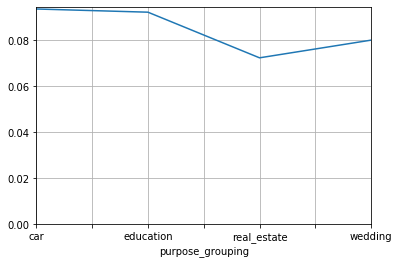

In [28]:
##Calculate the risk for each group and compare with a reference group (need to choose a reference group)
#Group by the new family_status_id and count
purpose_debt = data.groupby('purpose_grouping')['debt'].agg(['count', 'mean']).reset_index()
purpose_debt.columns = ['purpose_grouping', 'count', 'risk']
purpose_debt.head()
data.groupby('purpose_grouping')['debt'].mean().plot(grid = True, ylim = 0)

#Let choose car as reference group

RR_edu_car = purpose_debt.loc[1, 'risk']/purpose_debt.loc[0, 'risk']
RR_estate_car = purpose_debt.loc[2, 'risk']/purpose_debt.loc[0, 'risk']
RR_wed_car = purpose_debt.loc[3, 'risk']/purpose_debt.loc[0, 'risk']

print('The risk ratio for the loan for edu group compared to the loan for car group (the reference group) is {:.2f}'.format(RR_edu_car))
print('The risk ratio for the loan for real estate compared to the loan for car (the reference group) is {:.2f}'.format(RR_estate_car))
print('The risk ratio for the loan for wedding compared to the loan for car (the reference group) is {:.2f}'.format(RR_wed_car))


<font color = 'red'> Sub-conclusion 4: For the question "Is there a relation between purposes and repaying a loan on time?": Yes, there is a relation between income level and repaying a loan on time.
- Those who get loan to do things relating to car or education have the same risk of paying loan late
- Those who get loan to do things relating to real estate have lower risk of paying loan late compared to those who get loan for car
- Those who get loan to do things relating to wedding have lower risk of paying loan late compared to those who get loan for car </font>

### Conclusion

In order to find the answer for the questions about if there are associations between variables in the dataframe, it's necessary to categorize values into groups. 
- For variables that already have pre-defined categories, we can combine categories that share similar characteristics together to reduce the number of categories.
- For continuous/quantitative values, we can divide them into quantiles.
- For text/string values, we can use stemming method to extract the key words based on which to build corresponding categories.

## Step 3. Answer these questions

- Is there a relation between having kids and repaying a loan on time?

Yes, there is a relation between having kids and repaying a loan on time. The risk of getting debt (repaying a loan NOT on time) among people who have kids is higher compared (1.22 times) to those who don't have kids. 

### Conclusion

- Is there a relation between marital status and repaying a loan on time?

Yes, there is a relation between marital status and repaying a loan on time. Compared to people who are married, those who are not married have 1.22 times the risk of getting debt (not paying loan on time) (a 22% increase in risk), and those who are free from the bond of marriage have 0.86 times the risk (a 14% decrease in risk).

### Conclusion

- Is there a relation between income level and repaying a loan on time?

Yes, there is a relation between income level and repaying a loan on time. Compared to people with medium income, those who are at low income have 0.9 times the risk of getting debt (not paying loan on time) (a 10% decreasae in risk), and those who are at high income level have 0.77 times the risk (a 23% decrease in risk). 

### Conclusion

- How do different loan purposes affect on-time repayment of the loan?

    - Those who get loan to do things relating to car or education have the same risk of paying loan late
    - Those who get loan to do things relating to real estate have lower risk of paying loan late compared to those who get loan for car
    - Those who get loan to do things relating to wedding have lower risk of paying loan late compared to those who get loan for car

### Conclusion

In descriptive statistics (instead of inferiential statistics), data show there are associations between having kids, marital status, income level and loan purpose with on-time repayment of the loan. 

### Step 4. General conclusion

This dataset has been preprocessed with the following tasks: identifying and imputing for missing values, replacing data type, identifying and dropping duplicates, categorizing data and find relationships between variables. Because this is just descriptive analysis, associations are found by calculating some ratios and comparing them between categories. Results show on-time repayment of the loan are influenced by having kids, marital status, income level and loan purpose. Therefore, when deciding if the bank should loan a person, we need to relate to these determinants to reduce the risk of late loan repayment, or even worse, loan default. 